# Training of a Soft-Binarized Neural Network for CMOS RRAM Crossbar
 We introduce a new concept of Soft-Binarization during training. We approximate the ON state of the RRAM memory cell to be roughly of the conductance of G_ON always (valid upto a small signal limit). We train a neural network ex-situ while modelling this binary behaviour in the training phase itself.

Binarizing Weights will cause backpropagation to fail. While using a Straight-Through-Estimator is one option, we can just model a **"Soft Binarization"** with a Sigmoid or a Tanh instead. Thus we apply a Binarization to the weights during the forward pass, and let PyTorch compute the gradients in the backward pass and update the weights. This way, when we program the physical RRAM array, there is minimal deviation from what the training achieved

In [50]:
import numpy as np
import torch
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
from torchinfo import summary
import ast

In [15]:
def plot_loss_and_accuracy(loss_history, accuracy_history, num_epochs, element):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(range(1, num_epochs + 1), loss_history, label="Loss", color="blue")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")

    ax2 = ax1.twinx()
    ax2.plot(range(1, num_epochs + 1), accuracy_history, label="Accuracy", color="orange")
    ax2.set_ylabel("Accuracy (%)", color="orange")
    ax2.tick_params(axis="y", labelcolor="orange")

    plt.title("Loss and Accuracy vs. Epochs for "+ element)
    fig.tight_layout()
    plt.grid(True)
    plt.show()

## Data-set Preparation

In [16]:
A_true = np.array([
    [[0,1,1,0], [1,0,0,1], [1,1,1,1], [1,0,0,1]], 
    [[1,1,1,1], [1,0,0,1], [1,1,1,1], [1,0,0,1]], 
    [[0,1,1,0], [1,0,0,1], [1,1,1,1], [0,0,0,1]],
    [[1,1,1,1], [1,0,0,1], [1,1,1,1], [0,0,0,1]],
    [[0,1,1,0], [1,0,0,1], [1,1,1,1], [1,0,0,0]],
    [[1,1,1,1], [1,0,0,1], [1,1,1,1], [1,0,0,0]],
    [[0,1,0,0], [1,0,1,0], [1,1,1,0], [1,0,1,0]],
    [[0,0,1,0], [0,1,0,1], [0,1,1,1], [0,1,0,1]],
    [[1,1,1,0], [1,0,1,0], [1,1,1,0], [1,0,1,0]],
    [[0,1,1,1], [0,1,0,1], [0,1,1,1], [0,1,0,1]]])

T_true = np.array([
    [[1,1,1,1], [0,1,0,0], [0,1,0,0], [0,1,0,0]],
    [[1,1,1,1], [0,0,1,0], [0,0,1,0], [0,0,1,0]],
    [[1,1,1,0], [0,1,0,0], [0,1,0,0], [0,1,0,0]],
    [[0,1,1,1], [0,0,1,0], [0,0,1,0], [0,0,1,0]],
    [[1,1,1,1], [0,1,0,0], [0,1,0,0], [0,0,0,0]],
    [[1,1,1,1], [0,0,1,0], [0,0,1,0], [0,0,0,0]],
    [[1,1,1,0], [0,1,0,0], [0,1,0,0], [0,0,0,0]],
    [[0,1,1,1], [0,0,1,0], [0,0,1,0], [0,0,0,0]],
    [[0,0,0,0], [1,1,1,0], [0,1,0,0], [0,1,0,0]],
    [[0,0,0,0], [0,1,1,1], [0,0,1,0], [0,0,1,0]]])

V_true = np.array([
    [[1,0,0,1], [1,0,0,1], [1,0,0,1], [1,1,1,1]],
    [[1,0,0,1], [1,0,0,1], [1,0,0,1], [0,1,1,0]],
    [[1,0,1,0], [1,0,1,0], [1,0,1,0], [0,1,0,0]],
    [[0,1,0,1], [0,1,0,1], [0,1,0,1], [0,0,1,0]],
    [[0,0,0,0], [1,0,0,1], [1,0,0,1], [0,1,1,0]],
    [[0,0,0,0], [1,0,1,0], [1,0,1,0], [0,1,0,0]],
    [[0,0,0,0], [0,1,0,1], [0,1,0,1], [0,0,1,0]],
    [[1,0,1,0], [1,0,1,0], [0,1,0,0], [0,0,0,0]],
    [[0,1,0,1], [0,1,0,1], [0,0,1,0], [0,0,0,0]],
    [[1,0,0,1], [1,0,0,1], [0,1,1,0], [0,0,0,0]]])

X_true = np.array([
    [[1,0,1,0], [0,1,0,0], [1,0,1,0], [0,0,0,0]],
    [[0,0,0,0], [0,1,0,1], [0,0,1,0], [0,1,0,1]],
    [[0,0,0,0], [1,0,1,0], [0,1,0,0], [1,0,1,0]],
    [[0,1,0,1], [0,0,1,0], [0,1,0,1], [0,0,0,0]],
    [[1,0,1,0], [0,1,0,0], [1,0,1,0], [0,0,0,1]],
    [[1,0,0,0], [0,1,0,1], [0,0,1,0], [0,1,0,1]],
    [[0,0,0,1], [1,0,1,0], [0,1,0,0], [1,0,1,0]],
    [[0,1,0,1], [0,0,1,0], [0,1,0,1], [1,0,0,0]],
    [[0,1,0,1], [0,0,1,0], [0,1,0,1], [0,1,0,1]],
    [[1,0,1,0], [1,0,1,0], [0,1,0,0], [1,0,1,0]]])

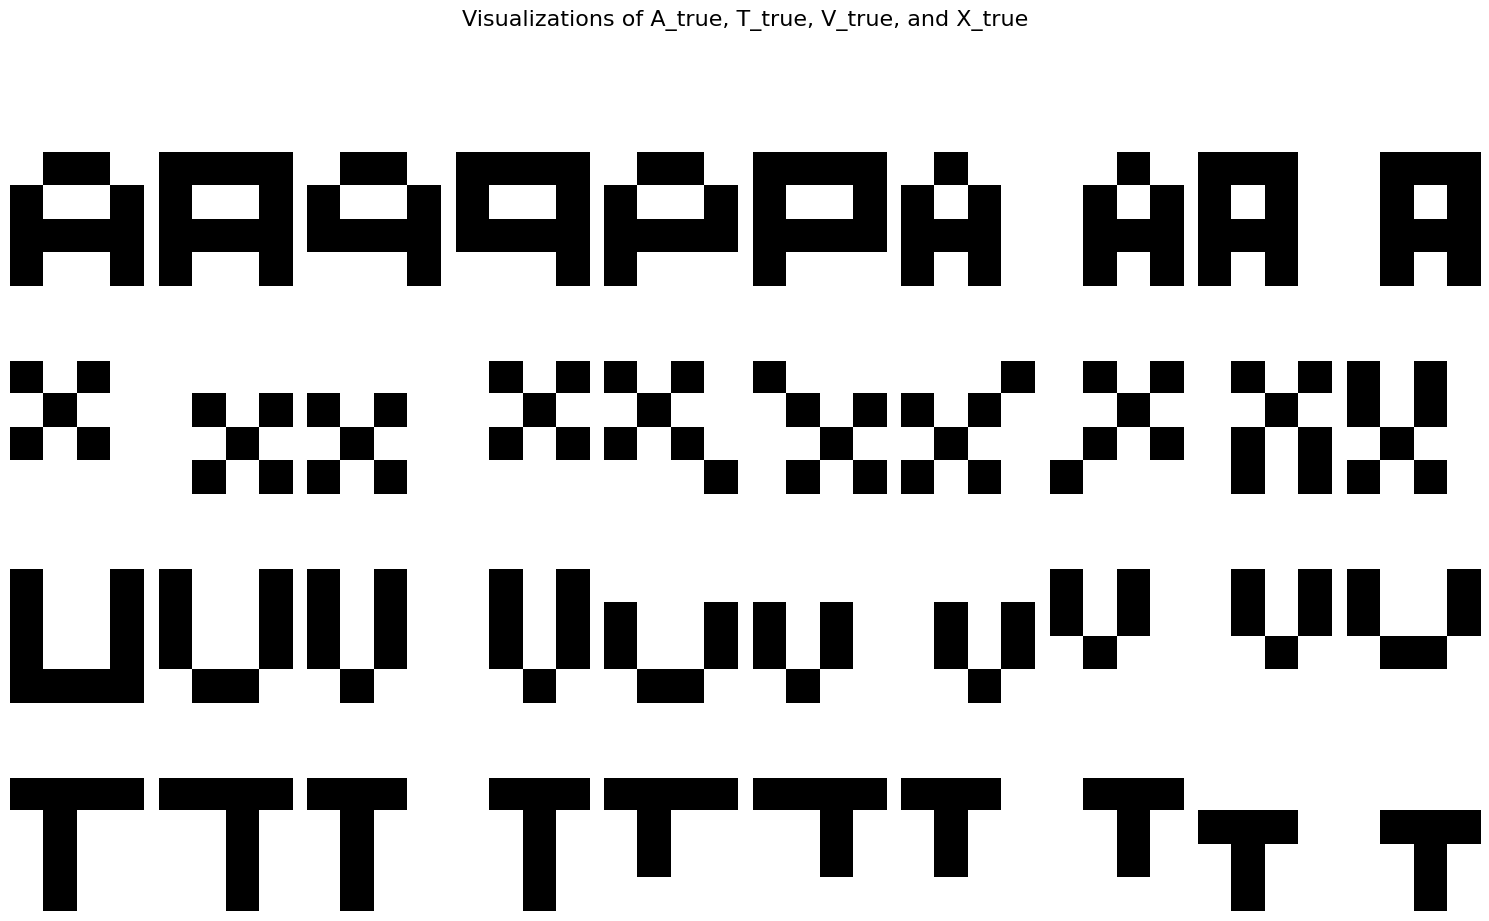

In [17]:
total_subplots = 4 * len(A_true)
fig, axes = plt.subplots(4, len(A_true), figsize=(15, 10))
fig.suptitle("Visualizations of A_true, T_true, V_true, and X_true", fontsize=16)

data_arrays = {"A": A_true, "X": X_true, "V": V_true, "T": T_true}

for row, (name, array) in enumerate(data_arrays.items()):
    for col in range(array.shape[0]):
        ax = axes[row, col]
        ax.imshow(1 - array[col], cmap="gray")
        ax.axis('off')
        if col == 0:
            ax.set_ylabel(name, fontsize=12)
        if row == len(data_arrays) - 1:
            ax.set_xlabel(f"Slice {col+1}", fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust space for the suptitle
plt.show()

### Validation Set

In [18]:
AUG = np.zeros((4, 160, 4, 4), dtype=np.uint8)
for idx, data in enumerate([A_true, T_true, V_true, X_true]):
    for sample in range(10):
        AUG[idx][sample * 16:(sample + 1) * 16] = data[sample]
        for i in range(4):
            for j in range(4):
                AUG[idx][sample * 16 + 4 * i + j][i][j] ^= 1  # Flip bits (abs(x-1))

A_AUG, T_AUG, V_AUG, X_AUG = AUG

val_inputs = torch.tensor(np.concatenate([A_AUG, T_AUG, V_AUG, X_AUG]), dtype=torch.float32)
val_labels = torch.tensor(
    np.concatenate([[i] * len(AUG[i]) for i in range(4)]), dtype=torch.long
)
val_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Training Set

In [19]:
A_true_tensor = torch.tensor(A_true, dtype=torch.float32)
X_true_tensor = torch.tensor(X_true, dtype=torch.float32)
V_true_tensor = torch.tensor(V_true, dtype=torch.float32)
T_true_tensor = torch.tensor(T_true, dtype=torch.float32)

train_inputs = torch.cat([A_true_tensor, X_true_tensor, V_true_tensor, T_true_tensor], dim=0)

num_samples_per_category = len(A_true)
train_labels = torch.cat([
    torch.full((num_samples_per_category,), 0, dtype=torch.long),
    torch.full((num_samples_per_category,), 1, dtype=torch.long),
    torch.full((num_samples_per_category,), 2, dtype=torch.long),
    torch.full((num_samples_per_category,), 3, dtype=torch.long),
])

In [20]:
train_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [21]:
def tensor_stats(tensor, name="Tensor"):
    mean_magnitude = tensor.abs().mean().item()
    print(f"{name} - Mean Magnitude: {mean_magnitude:.2e}, Max: {tensor.max().item():.2e}, Min: {tensor.min().item():.2e}")

## Custom Neural Network

1. **RRAMs/FeFETs** have only ON and OFF states that can be reliably controlled. A Sigmoid Function can be used to approximate this Binary behaviour. Hence we apply a Sigmoid on all weights before using them in the Fully Connected Layer. **G_ON** and **G_OFF** are the limits of this Sigmoid, where we approximate all ON RRAMs/FeFETs to have a conductance of G_ON and similarly for G_OFF.
2. Every Crossbar must be followed by an **Opamp or an Inverter** that is connect in Negative Feedback so that the Current Mode signal is converted to a Voltage mode. This also serves as the activation function. This again is a Sigmoid/Tanh, where the slope at the centre is the Feedback Resistance of the Amplifier **R_INV** and the Rails are limited by **V_INV**.
3. The input voltages are given by **V_1** which corresponds to the reading voltage and **V_0** which corresponds to the OFF voltage (=0)

In [22]:
class BinaryNeuralNetwork(nn.Module):
    def __init__(self, G_ON, G_OFF, V_INV, R_INV, R_INV2, V_1, V_0, sharpness, initial_factor, h_layer = 8, verbose = False):
        super(BinaryNeuralNetwork, self).__init__()
        
        self.w1 = nn.Parameter(torch.empty(h_layer, 16))
        self.w2 = nn.Parameter(torch.empty(4, h_layer))
        nn.init.xavier_uniform_(self.w1)
        nn.init.xavier_uniform_(self.w2)

        self.G_ON = G_ON
        self.G_OFF = G_OFF
        self.V_INV = V_INV
        self.R_INV = R_INV
        self.R_INV2 = R_INV2
        self.V_1 = V_1
        self.V_0 = V_0

        self.sharpness = sharpness

        self.w1.data = initial_factor*self.w1
        self.w2.data = initial_factor*self.w2

        self.verbose = verbose
        
    def forward(self, x):
        # Preprocessing: Two States of input (V_ON and V_OFF)
        x = (self.V_1 - self.V_0) * x.view(x.size(0), -1) + self.V_0

        # RRAM Soft Binarization
        g1 = ((self.G_ON - self.G_OFF) * torch.sigmoid(self.w1 * self.sharpness) + self.G_OFF).to(x.device)
        g2 = ((self.G_ON - self.G_OFF) * torch.sigmoid(self.w2 * self.sharpness) + self.G_OFF).to(x.device)
        
        if self.verbose:
            tensor_stats(self.w1, "\nLatent Weights FC1")
            tensor_stats(self.w2, "Latent Weights FC2")
            tensor_stats(g1, "\nSoft Binarized Weights FC1")
            tensor_stats(g2, "Soft Binarized FC2")
        
        # Action of the Crossbar 1 
        x = F.linear(x, g1)
        if self.verbose: tensor_stats(x, "\nCurrents after Crossbar 1")
        
        # Action of Inverting Amplifier
        x = -self.V_INV * torch.tanh(self.R_INV * x / self.V_INV)
        if self.verbose: tensor_stats(x, "Voltage after Inv Amp 1")
        
        # Action of Crossbar 2
        x = F.linear(x, g2)
        if self.verbose: tensor_stats(x, "\nCurrents after Crossbar 2")
        
        # Action of Inverting Amplifier
        x = -self.V_INV * torch.tanh(self.R_INV2 * x/ self.V_INV)
        if self.verbose: tensor_stats(x, "Voltage after Inv Amp 2")
                
        return x
        
    def backprop(self, lr):
        if self.verbose:
            tensor_stats(lr * self.w1.grad, "\nLatent Gradients FC1")
            tensor_stats(lr * self.w2.grad, "Latent Gradients FC2")
    
        with torch.no_grad():
            self.w1 -= lr * self.w1.grad
            self.w2 -= lr * self.w2.grad
    
        self.w1.grad.zero_()
        self.w2.grad.zero_()

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()  

### Data Augmentation

For training purposes, we can superimpose noise onto the letters. We will have some amount of noise in the circuit too. This will help in generalizing for analog noise in the hardware too

In [35]:
class AugmentedDataset(Dataset):
    def __init__(self, images, labels, noise_std=0.1):
        self.images = images
        self.labels = labels
        self.noise_std = noise_std

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        noisy_image = image + torch.randn_like(image) * self.noise_std
        return noisy_image, label

noise_std = 0.25
augmented_dataset = AugmentedDataset(train_inputs, train_labels, noise_std=noise_std)
dataloader = DataLoader(augmented_dataset, batch_size=10, shuffle=True)

# Model for RRAM

G_ON and G_OFF for a FeFET of dimensions similar to that we used in Endsem was 7.7e-5 and 2.88e-6 respectively

In [36]:
params_RRAM = {
    "G_ON": 7.7e-5,
    "G_OFF": 2.88e-6,
    "V_INV": 5,
    "R_INV": 5e+3,
    "R_INV2": 5e+3,
    "V_1": 0.1,
    "V_0": -0.1,
    "sharpness": 100,
    "initial_factor": 0.25,
    "h_layer": 8,
    "verbose": False
}

model_RRAM = BinaryNeuralNetwork(**params_RRAM).to(device)
summary(model_RRAM)

Layer (type:depth-idx)                   Param #
BinaryNeuralNetwork                      160
Total params: 160
Trainable params: 160
Non-trainable params: 0

In [37]:
try:
    with open("RRAM_loss.txt", 'r') as f: lowest_loss_RRAM = float(f.read())
except:
    lowest_loss_RRAM = float('inf')
print(lowest_loss_RRAM)

1.241766


#### Training Notes:
1. **R_INV** and **V_INV** should be chosen carefully. If these are too small, the backpropagation gradients will diminish before it reaches the first fully connected later. While **sharpness** and **initial_factor** are purely software parameters and don't correspond to anything in the circuit, but these also affect how the training goes because the gradient in the backward pass through the soft binarization depends on these
2. **R_INV** cannot be made too large either. The approximation that **G_ON** is constant with respect to input voltage holds only to a small signal limit. While this is not a problem in the first fully connected layer, the second layer must be monitored. Hence, **verbose = True** must be set above and the intermediate voltage must be monitored to ensure that we don't enter the non-linear region of current vs reading voltage.

In [42]:
lr = 1
num_epochs = 500
loss_history_RRAM = []
accuracy_history_RRAM = []

for epoch in range(num_epochs):
    if epoch == 0:
        lr /= 1024
    elif epoch <= 10:
        lr *= 2

    model_RRAM.train()

    epoch_loss = 0
    epoch_accuracy = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_RRAM(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        model_RRAM.backprop(lr)

        epoch_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, dim=1)
        epoch_accuracy += (predictions == labels).sum().item()
        total_samples += inputs.size(0)

    epoch_loss /= total_samples
    epoch_accuracy = (epoch_accuracy / total_samples) * 100

    loss_history_RRAM.append(epoch_loss)
    accuracy_history_RRAM.append(epoch_accuracy)

    # Check and update the lowest loss
    if epoch_loss < lowest_loss_RRAM:
        lowest_loss_RRAM = epoch_loss
        with open("RRAM_loss.txt", "w") as f: f.write(f"{lowest_loss_RRAM:.6f}")
        with open("RRAM_params.txt", "w") as f: f.write(f"{params_RRAM}")
        model_filename = f"RRAM_model.pth"
        torch.save(model_RRAM.state_dict(), model_filename)
        print(f"Model saved: {model_filename}")

    if epoch % (num_epochs // 10) == 0 or epoch <= 10:
        print(f"Epoch {epoch + 1}, LR: {lr:.4f}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    if epoch%(num_epochs // 3) == 0 and epoch!=0:
        lr /= 2

Epoch 1, LR: 0.0010, Loss: 1.2483, Accuracy: 52.50%
Epoch 2, LR: 0.0020, Loss: 1.2385, Accuracy: 57.50%
Epoch 3, LR: 0.0039, Loss: 1.2453, Accuracy: 57.50%
Epoch 4, LR: 0.0078, Loss: 1.2394, Accuracy: 57.50%
Epoch 5, LR: 0.0156, Loss: 1.2452, Accuracy: 52.50%
Epoch 6, LR: 0.0312, Loss: 1.2394, Accuracy: 60.00%
Epoch 7, LR: 0.0625, Loss: 1.2484, Accuracy: 57.50%
Epoch 8, LR: 0.1250, Loss: 1.2411, Accuracy: 55.00%
Epoch 9, LR: 0.2500, Loss: 1.2370, Accuracy: 60.00%
Epoch 10, LR: 0.5000, Loss: 1.2374, Accuracy: 55.00%
Epoch 11, LR: 1.0000, Loss: 1.2546, Accuracy: 55.00%
Epoch 51, LR: 1.0000, Loss: 1.2416, Accuracy: 55.00%
Epoch 101, LR: 1.0000, Loss: 1.2407, Accuracy: 55.00%
Epoch 151, LR: 1.0000, Loss: 1.2456, Accuracy: 57.50%
Epoch 201, LR: 0.5000, Loss: 1.2525, Accuracy: 57.50%
Epoch 251, LR: 0.5000, Loss: 1.2445, Accuracy: 55.00%
Epoch 301, LR: 0.5000, Loss: 1.2351, Accuracy: 55.00%
Epoch 351, LR: 0.2500, Loss: 1.2447, Accuracy: 55.00%
Epoch 401, LR: 0.2500, Loss: 1.2530, Accuracy: 62

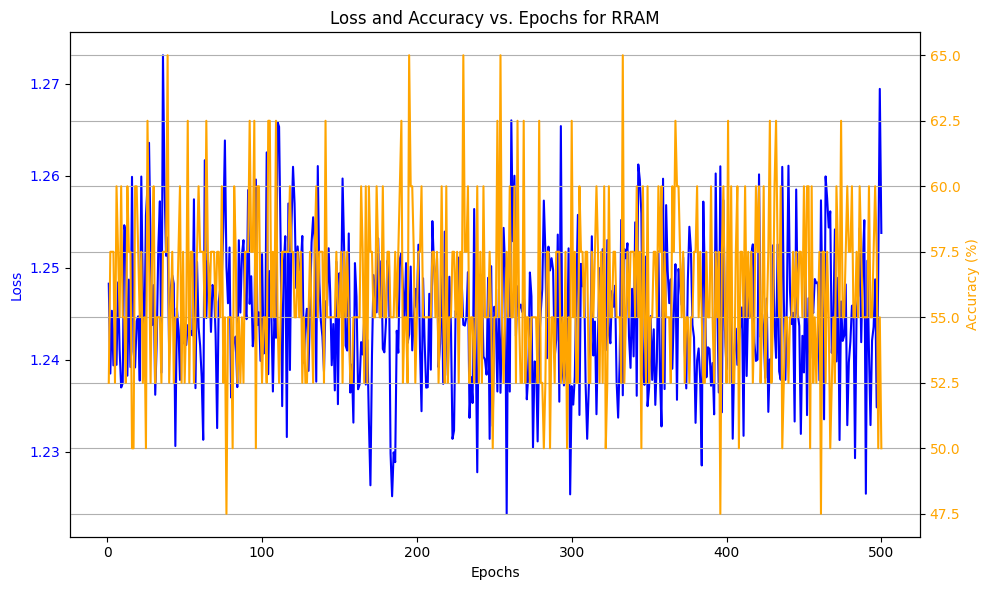

In [43]:
plot_loss_and_accuracy(loss_history_RRAM, accuracy_history_RRAM, num_epochs, "RRAM")

### Testing Accuracy and Loss:

In [51]:
with open("RRAM_params.txt", 'r') as f: params_RRAM_best = ast.literal_eval(f.read())
model_RRAM_best = BinaryNeuralNetwork(**params_RRAM_best)
model_RRAM_best.load_state_dict(torch.load("RRAM_model.pth"))

<All keys matched successfully>

In [52]:
val_inputs = val_inputs.to(device) 
val_labels = val_labels.to(device)

model_RRAM.eval()

with torch.no_grad():
    outputs = model_RRAM(val_inputs)
    loss = criterion(outputs, val_labels)
    _, predicted = torch.max(outputs, dim=1)
    correct = (predicted == val_labels).sum().item()
    accuracy = correct / val_labels.size(0)

print(f"Validation Loss: {loss.item():.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Loss: 1.2720
Validation Accuracy: 51.88%


# Model for FeFET

G_ON and G_OFF for a FeFET of dimensions similar to that we used in Assignment 5 is __ and __ respectively

In [31]:
params_FeFET = {
    "G_ON": 5e-5,
    "G_OFF": 1e-9,
    "V_INV": 5,
    "R_INV": 1e+6,
    "R_INV2": 1e+6,
    "V_1": 0.1,
    "V_0": 0,
    "sharpness": 1000,
    "initial_factor": 1,
    "h_layer": 8,
    "verbose": False
}
model_FeFET = BinaryNeuralNetwork(**params_FeFET).to(device)
summary(model_FeFET)

Layer (type:depth-idx)                   Param #
BinaryNeuralNetwork                      160
Total params: 160
Trainable params: 160
Non-trainable params: 0

In [32]:
try:
    with open("FeFET_loss.txt", 'r') as f: lowest_loss_FeFET = float(f.read())
except:
    lowest_loss_FeFET = float('inf')
print(lowest_loss_FeFET)

1.347178


In [33]:
lr = 1
num_epochs = 500
loss_history_FeFET = []
accuracy_history_FeFET = []

for epoch in range(num_epochs):
    if epoch == 0:
        lr /= 1024
    elif epoch <= 10:
        lr *= 2

    model_FeFET.train()

    epoch_loss = 0
    epoch_accuracy = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_FeFET(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        model_FeFET.backprop(lr)

        epoch_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, dim=1)
        epoch_accuracy += (predictions == labels).sum().item()
        total_samples += inputs.size(0)

    epoch_loss /= total_samples
    epoch_accuracy = (epoch_accuracy / total_samples) * 100

    loss_history_FeFET.append(epoch_loss)
    accuracy_history_FeFET.append(epoch_accuracy)

    # Check and update the lowest loss
    if epoch_loss < lowest_loss_FeFET:
        lowest_loss_FeFET = epoch_loss
        with open("FeFET_loss.txt", "w") as f: f.write(f"{lowest_loss_FeFET:.6f}")
        with open("FeFET_params.txt", "w") as f: f.write(f"{params_FeFET}")
        model_filename = f"FeFET_model.pth"
        torch.save(model_FeFET.state_dict(), model_filename)
        print(f"Model saved: {model_filename}")

    if epoch % (num_epochs // 10) == 0 or epoch <= 10:
        print(f"Epoch {epoch + 1}, LR: {lr:.4f}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    if epoch%(num_epochs // 3) == 0 and epoch!=0:
        lr /= 2

Epoch 1, LR: 0.0010, Loss: 1.3863, Accuracy: 25.00%
Epoch 2, LR: 0.0020, Loss: 1.3863, Accuracy: 25.00%
Epoch 3, LR: 0.0039, Loss: 1.3863, Accuracy: 25.00%
Epoch 4, LR: 0.0078, Loss: 1.3863, Accuracy: 25.00%
Epoch 5, LR: 0.0156, Loss: 1.3863, Accuracy: 25.00%
Epoch 6, LR: 0.0312, Loss: 1.3863, Accuracy: 25.00%
Epoch 7, LR: 0.0625, Loss: 1.3863, Accuracy: 25.00%
Epoch 8, LR: 0.1250, Loss: 1.3863, Accuracy: 25.00%
Epoch 9, LR: 0.2500, Loss: 1.3863, Accuracy: 25.00%
Epoch 10, LR: 0.5000, Loss: 1.3863, Accuracy: 25.00%
Epoch 11, LR: 1.0000, Loss: 1.3863, Accuracy: 25.00%
Epoch 51, LR: 1.0000, Loss: 1.3863, Accuracy: 25.00%
Epoch 101, LR: 1.0000, Loss: 1.3863, Accuracy: 25.00%
Epoch 151, LR: 1.0000, Loss: 1.3863, Accuracy: 25.00%
Epoch 201, LR: 0.5000, Loss: 1.3863, Accuracy: 25.00%
Epoch 251, LR: 0.5000, Loss: 1.3863, Accuracy: 25.00%
Epoch 301, LR: 0.5000, Loss: 1.3863, Accuracy: 25.00%
Epoch 351, LR: 0.2500, Loss: 1.3863, Accuracy: 25.00%
Epoch 401, LR: 0.2500, Loss: 1.3863, Accuracy: 25

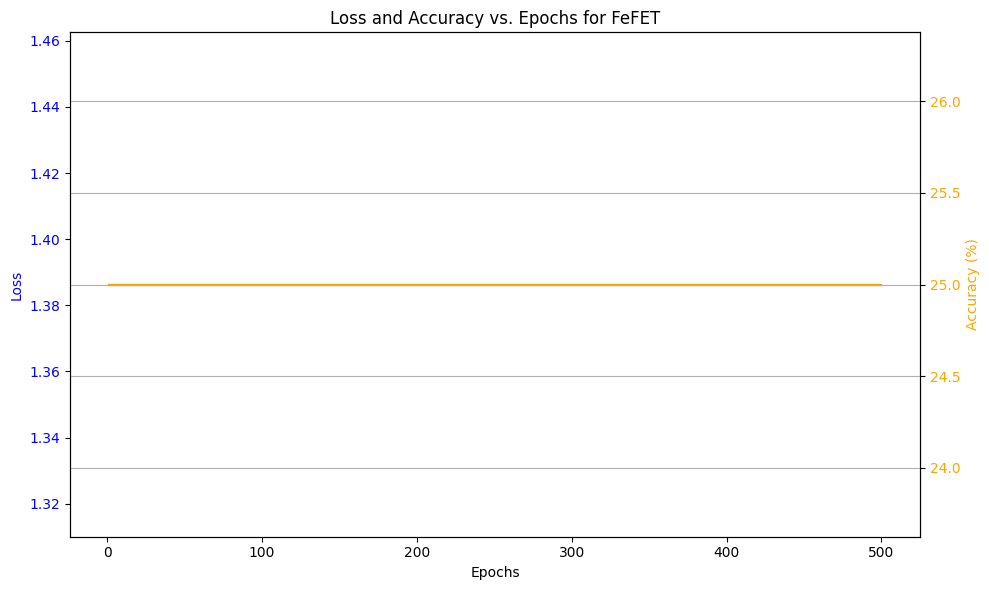

In [34]:
plot_loss_and_accuracy(loss_history_FeFET, accuracy_history_FeFET, num_epochs, "FeFET")